In [1]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, SecondLocator, DateFormatter


import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import scipy
import pyarrow

import inference
import learning
import torch

import aeon
import aeon.io.api as api
from aeon.io import reader, video
from aeon.schema.dataset import exp02
from aeon.analysis.utils import visits, distancetravelled

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import pymc3 as pm

import patch
import kinematics

In [2]:
!ls /ceph/aeon

aeon			 aeon_transfer.log  rmhzbm0  test2
aeon_transfer_final.log  db_dumps	    test


In [3]:
# Long, individual session
root = [Path("/ceph/aeon/aeon/data/raw/AEON2/experiment0.2")]

# Ensure root exists
if not np.all([path.exists() for path in root]):
    print("Cannot find root paths. Check path names or connection.")
    
Exp02Summary = api.load(root, exp02.Metadata).metadata[0].toDict()
Patch_Pos = [device['Regions']['ArrayOfPoint'] for device in Exp02Summary['Devices'] if device['Name'].startswith('ActivityPatch')]

subject_events = api.load(root, exp02.ExperimentalMetadata.SubjectState)
sessions = visits(subject_events[subject_events.id.str.startswith("BAA-")])

# Choose Valid Sessions

In [4]:
sessions_ = sessions.iloc[[4,8,10,11,14,16,17,20,23,24,25,26,28,29,30,31]]
short_sessions = sessions.iloc[[4,16,17,20,23,24,25,26,28,29,30,31]]
long_sessions = sessions.iloc[[8, 10, 11, 14]]

In [6]:
long_sessions

,id,weight_enter,weight_exit,enter,exit,duration
8,BAA-1100699,26.75,29.0,2022-03-29 13:11:37.277699947,2022-04-04 09:16:51.086110115,5 days 20:05:13.808410168
10,BAA-1100701,26.70,30.6,2022-04-04 15:54:07.945059776,2022-04-08 16:34:36.183650017,4 days 00:40:28.238590241
11,BAA-1100699,29.00,28.2,2022-04-20 11:51:24.997630119,2022-04-28 10:02:56.655809879,7 days 22:11:31.658179760
14,BAA-1100702,27.00,28.9,2022-05-03 11:08:12.660739899,2022-05-12 09:21:42.411650181,8 days 22:13:29.750910282


# Load HMM

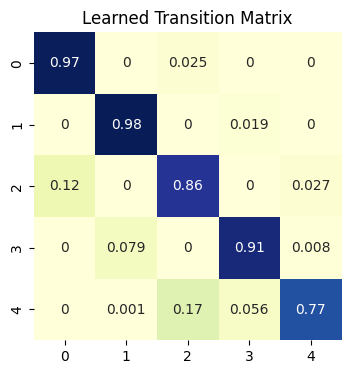

In [8]:
title = 'LongSession1'
transition_mat =  np.load(title+"Transition_1.npy", allow_pickle=True)
annot_array = np.array([[round(item, 3) for item in row] for row in transition_mat])
fig, axs = plt.subplots(1,1, figsize=(4, 4))
sns.heatmap(transition_mat, cmap='YlGnBu', ax = axs, square = 'True', cbar = False, annot=annot_array, annot_kws = {'size':10})
axs.set_title("Learned Transition Matrix")
plt.show()  

LongSession0


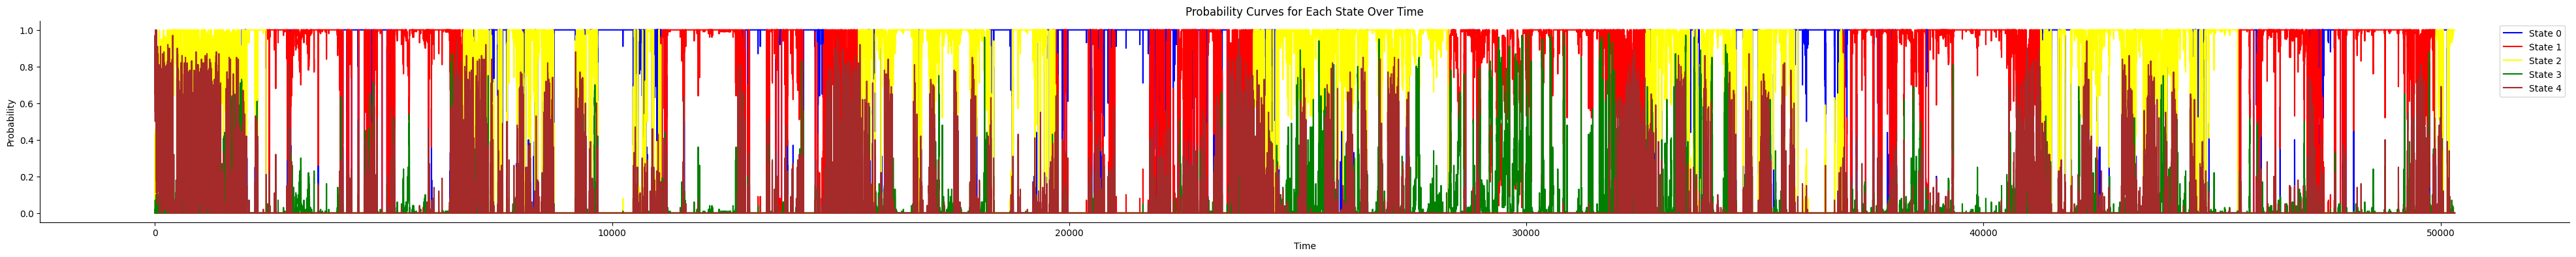

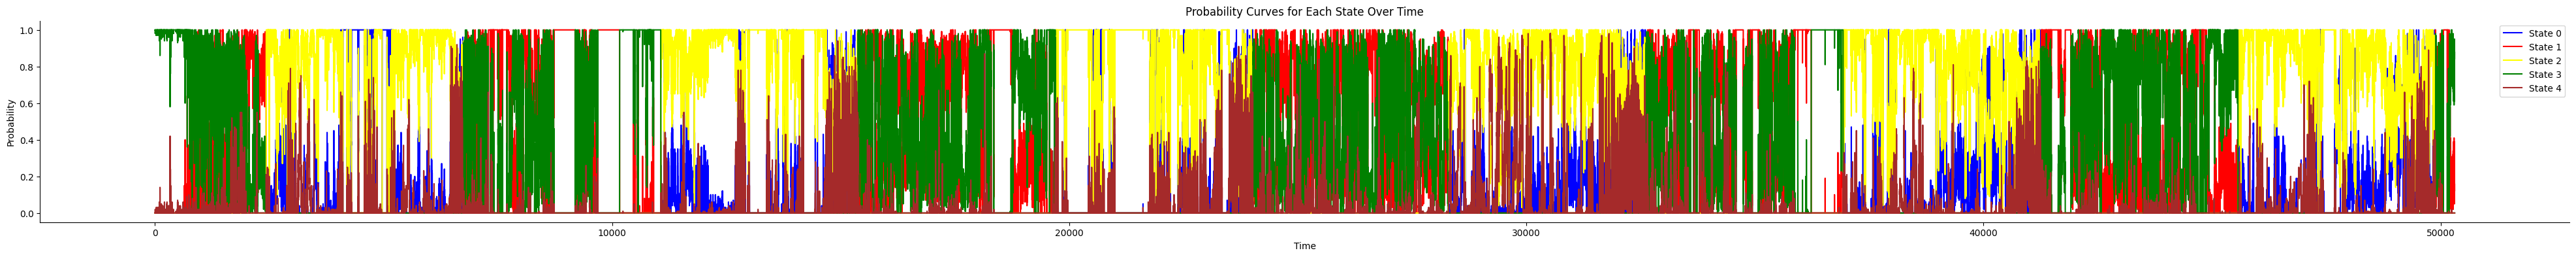

LongSession1


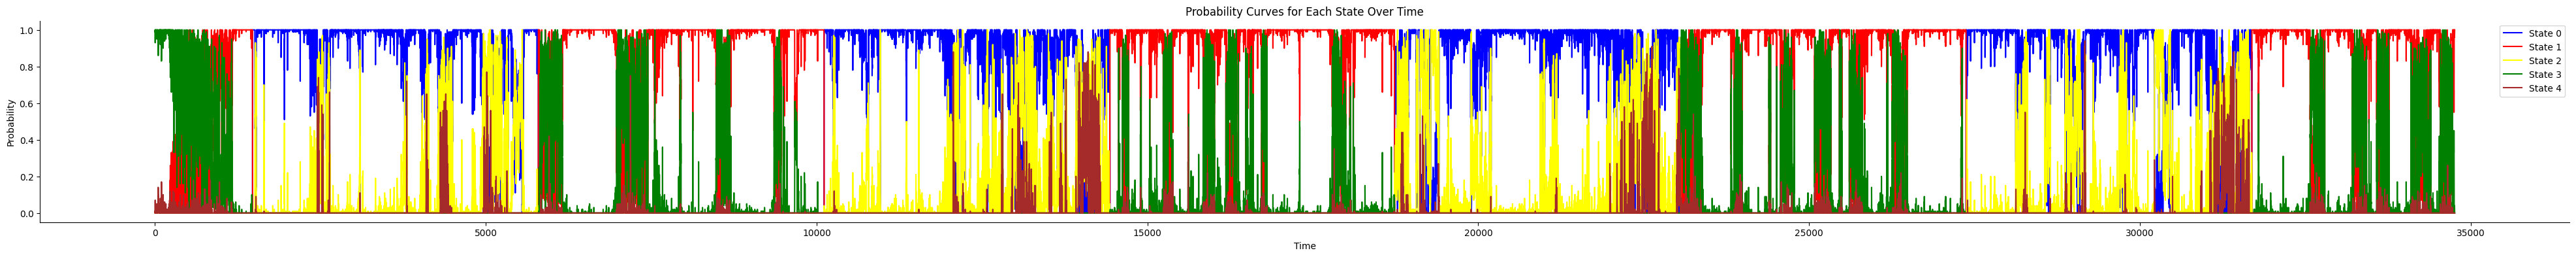

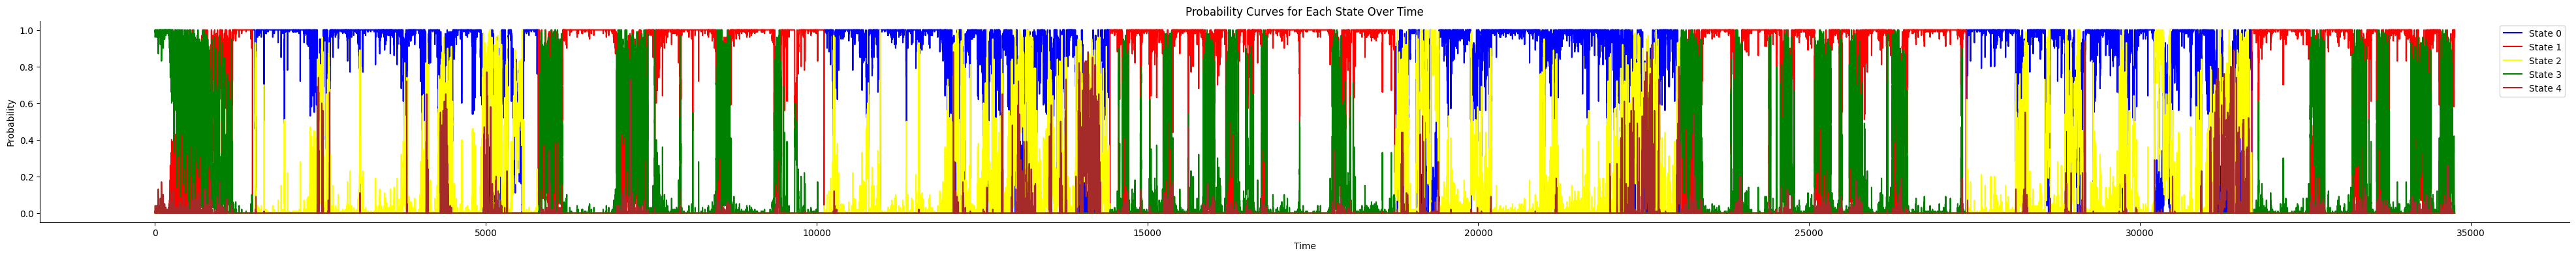

LongSession2


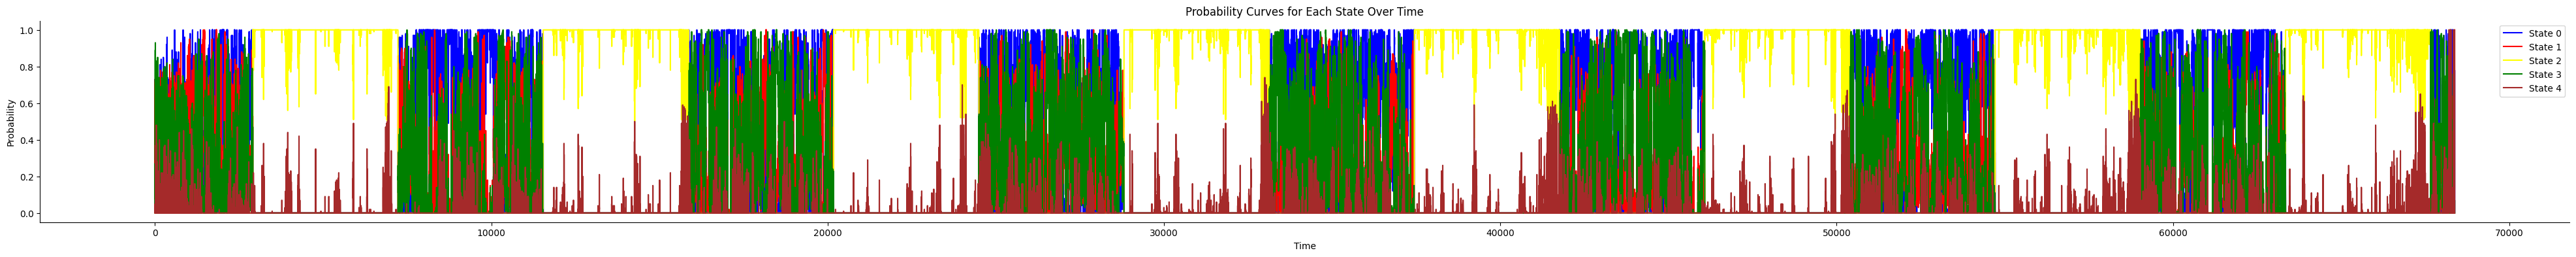

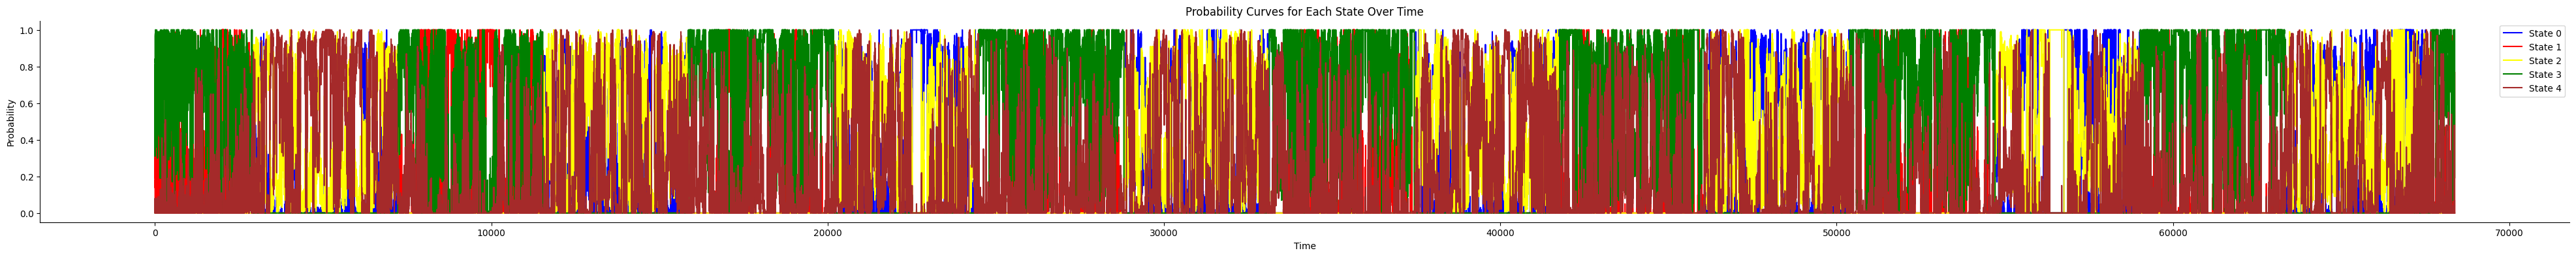

In [7]:
color_names = np.array(["blue","red","yellow", "green","brown"])

for session, j in zip(list(long_sessions.itertuples()), range(len(long_sessions))):
    if j == 3: continue
    title = 'LongSession'+str(j)
    print(title)
    
    states = np.load(title+"States.npy", allow_pickle = True)

    num_bins = len(states) // 100

    # Reshape the array to segment into bins of 100, ignoring the remainder for now
    bins = states[:num_bins * 100].reshape(-1, 100)

    # Initialize a dictionary to hold the probabilities for each state
    state_probabilities = {state: [] for state in np.unique(states)}

    # Calculate the probabilities for each bin
    for bin in bins:
        # Count the occurrences of each state in the bin
        counts = np.bincount(bin, minlength=len(state_probabilities))
        
        # Calculate the probability for each state and update the dictionary
        for state in state_probabilities:
            state_probabilities[state].append(counts[state] / 100.0)

    # If you have a remainder, calculate its state probabilities separately
    remainder = len(states) % 100
    if remainder != 0:
        last_bin = states[-remainder:]
        counts = np.bincount(last_bin, minlength=len(state_probabilities))
        for state in state_probabilities:
            state_probabilities[state].append(counts[state] / remainder)
    
    fig, axs = plt.subplots(1,1,figsize = (50, 4))
    for state in range(5): 
        axs.plot(state_probabilities[state], label=f'State {state}', color = color_names[state])

    axs.set_xlabel('Time')
    axs.set_ylabel('Probability')
    axs.set_title('Probability Curves for Each State Over Time')
    axs.spines['top'].set_visible(False)
    axs.spines['right'].set_visible(False)
    axs.legend()
    plt.show()
    
    states = np.load(title+"States_1.npy", allow_pickle = True)

    num_bins = len(states) // 100

    # Reshape the array to segment into bins of 100, ignoring the remainder for now
    bins = states[:num_bins * 100].reshape(-1, 100)

    # Initialize a dictionary to hold the probabilities for each state
    state_probabilities = {state: [] for state in np.unique(states)}

    # Calculate the probabilities for each bin
    for bin in bins:
        # Count the occurrences of each state in the bin
        counts = np.bincount(bin, minlength=len(state_probabilities))
        
        # Calculate the probability for each state and update the dictionary
        for state in state_probabilities:
            state_probabilities[state].append(counts[state] / 100.0)

    # If you have a remainder, calculate its state probabilities separately
    remainder = len(states) % 100
    if remainder != 0:
        last_bin = states[-remainder:]
        counts = np.bincount(last_bin, minlength=len(state_probabilities))
        for state in state_probabilities:
            state_probabilities[state].append(counts[state] / remainder)
    
    fig, axs = plt.subplots(1,1,figsize = (50, 4))
    for state in range(5): 
        axs.plot(state_probabilities[state], label=f'State {state}', color = color_names[state])

    axs.set_xlabel('Time')
    axs.set_ylabel('Probability')
    axs.set_title('Probability Curves for Each State Over Time')
    axs.spines['top'].set_visible(False)
    axs.spines['right'].set_visible(False)
    axs.legend()
    plt.show()